In [231]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib

data = pd.read_csv('../Prepared_Data/data.csv')

In [232]:
##### Set the Plot Sheme #####

# this provides the color palette of Uni Tuebingen
from tueplots.constants.color import rgb
# e.g. as rgb.tue_blue, rgb.tue_red, etc.

# set plotting stylesheet
# plt.rcParams.update(bundles.icml2022(column='full', nrows=1, ncols=2, usetex=False))
plt.style.use('default') 
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['font.size'] = 21
plt.rcParams['font.family'] = 'Times'
plt.rcParams['axes.labelsize'] = 21
plt.rcParams['axes.titlesize'] = 21

In [233]:
##### Cluster data #####

# remove rows that have values missing
data = data.dropna()

# calculate correlation between 'year' and each complexity factor
correlation_with_year = data[['year', 'number_of_parts', 'minifig_quantitiy', 'number_of_colors',
                                   'number_of_categories', 'number_of_unique_parts', 'number_of_different_parts',
                                   'not_unique_parts', 'proportion_unique_to_not_unique']].corr()['year']


print(correlation_with_year)

# select relevant columns for clustering
columns_for_clustering = ['number_of_parts', 'minifig_quantitiy', 'number_of_colors',
                           'number_of_categories', 'number_of_unique_parts',
                           'number_of_different_parts', 'not_unique_parts']

# extract the selected columns for clustering
data_for_clustering = data[columns_for_clustering]

# impute missing values using mean strategy
imputer = SimpleImputer(strategy='mean')
data_for_clustering_imputed = imputer.fit_transform(data_for_clustering)

# standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering_imputed)

# determine the optimal number of clusters using the elbow method
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

year                               1.000000
number_of_parts                    0.163838
minifig_quantitiy                  0.135465
number_of_colors                   0.384874
number_of_categories               0.292255
number_of_unique_parts             0.259474
number_of_different_parts          0.224974
not_unique_parts                   0.153657
proportion_unique_to_not_unique    0.029541
Name: year, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

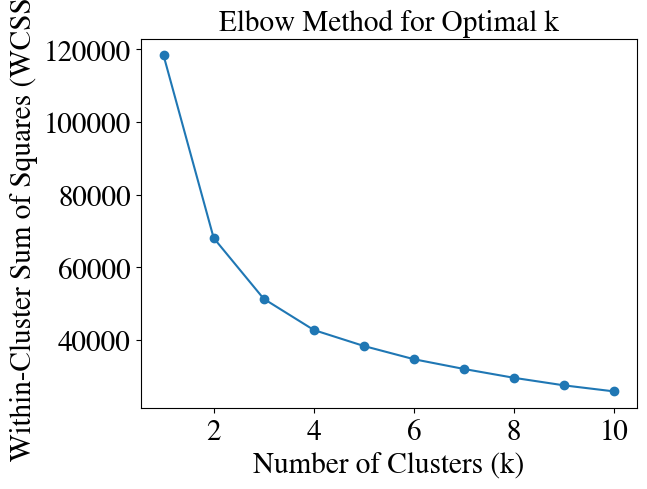

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


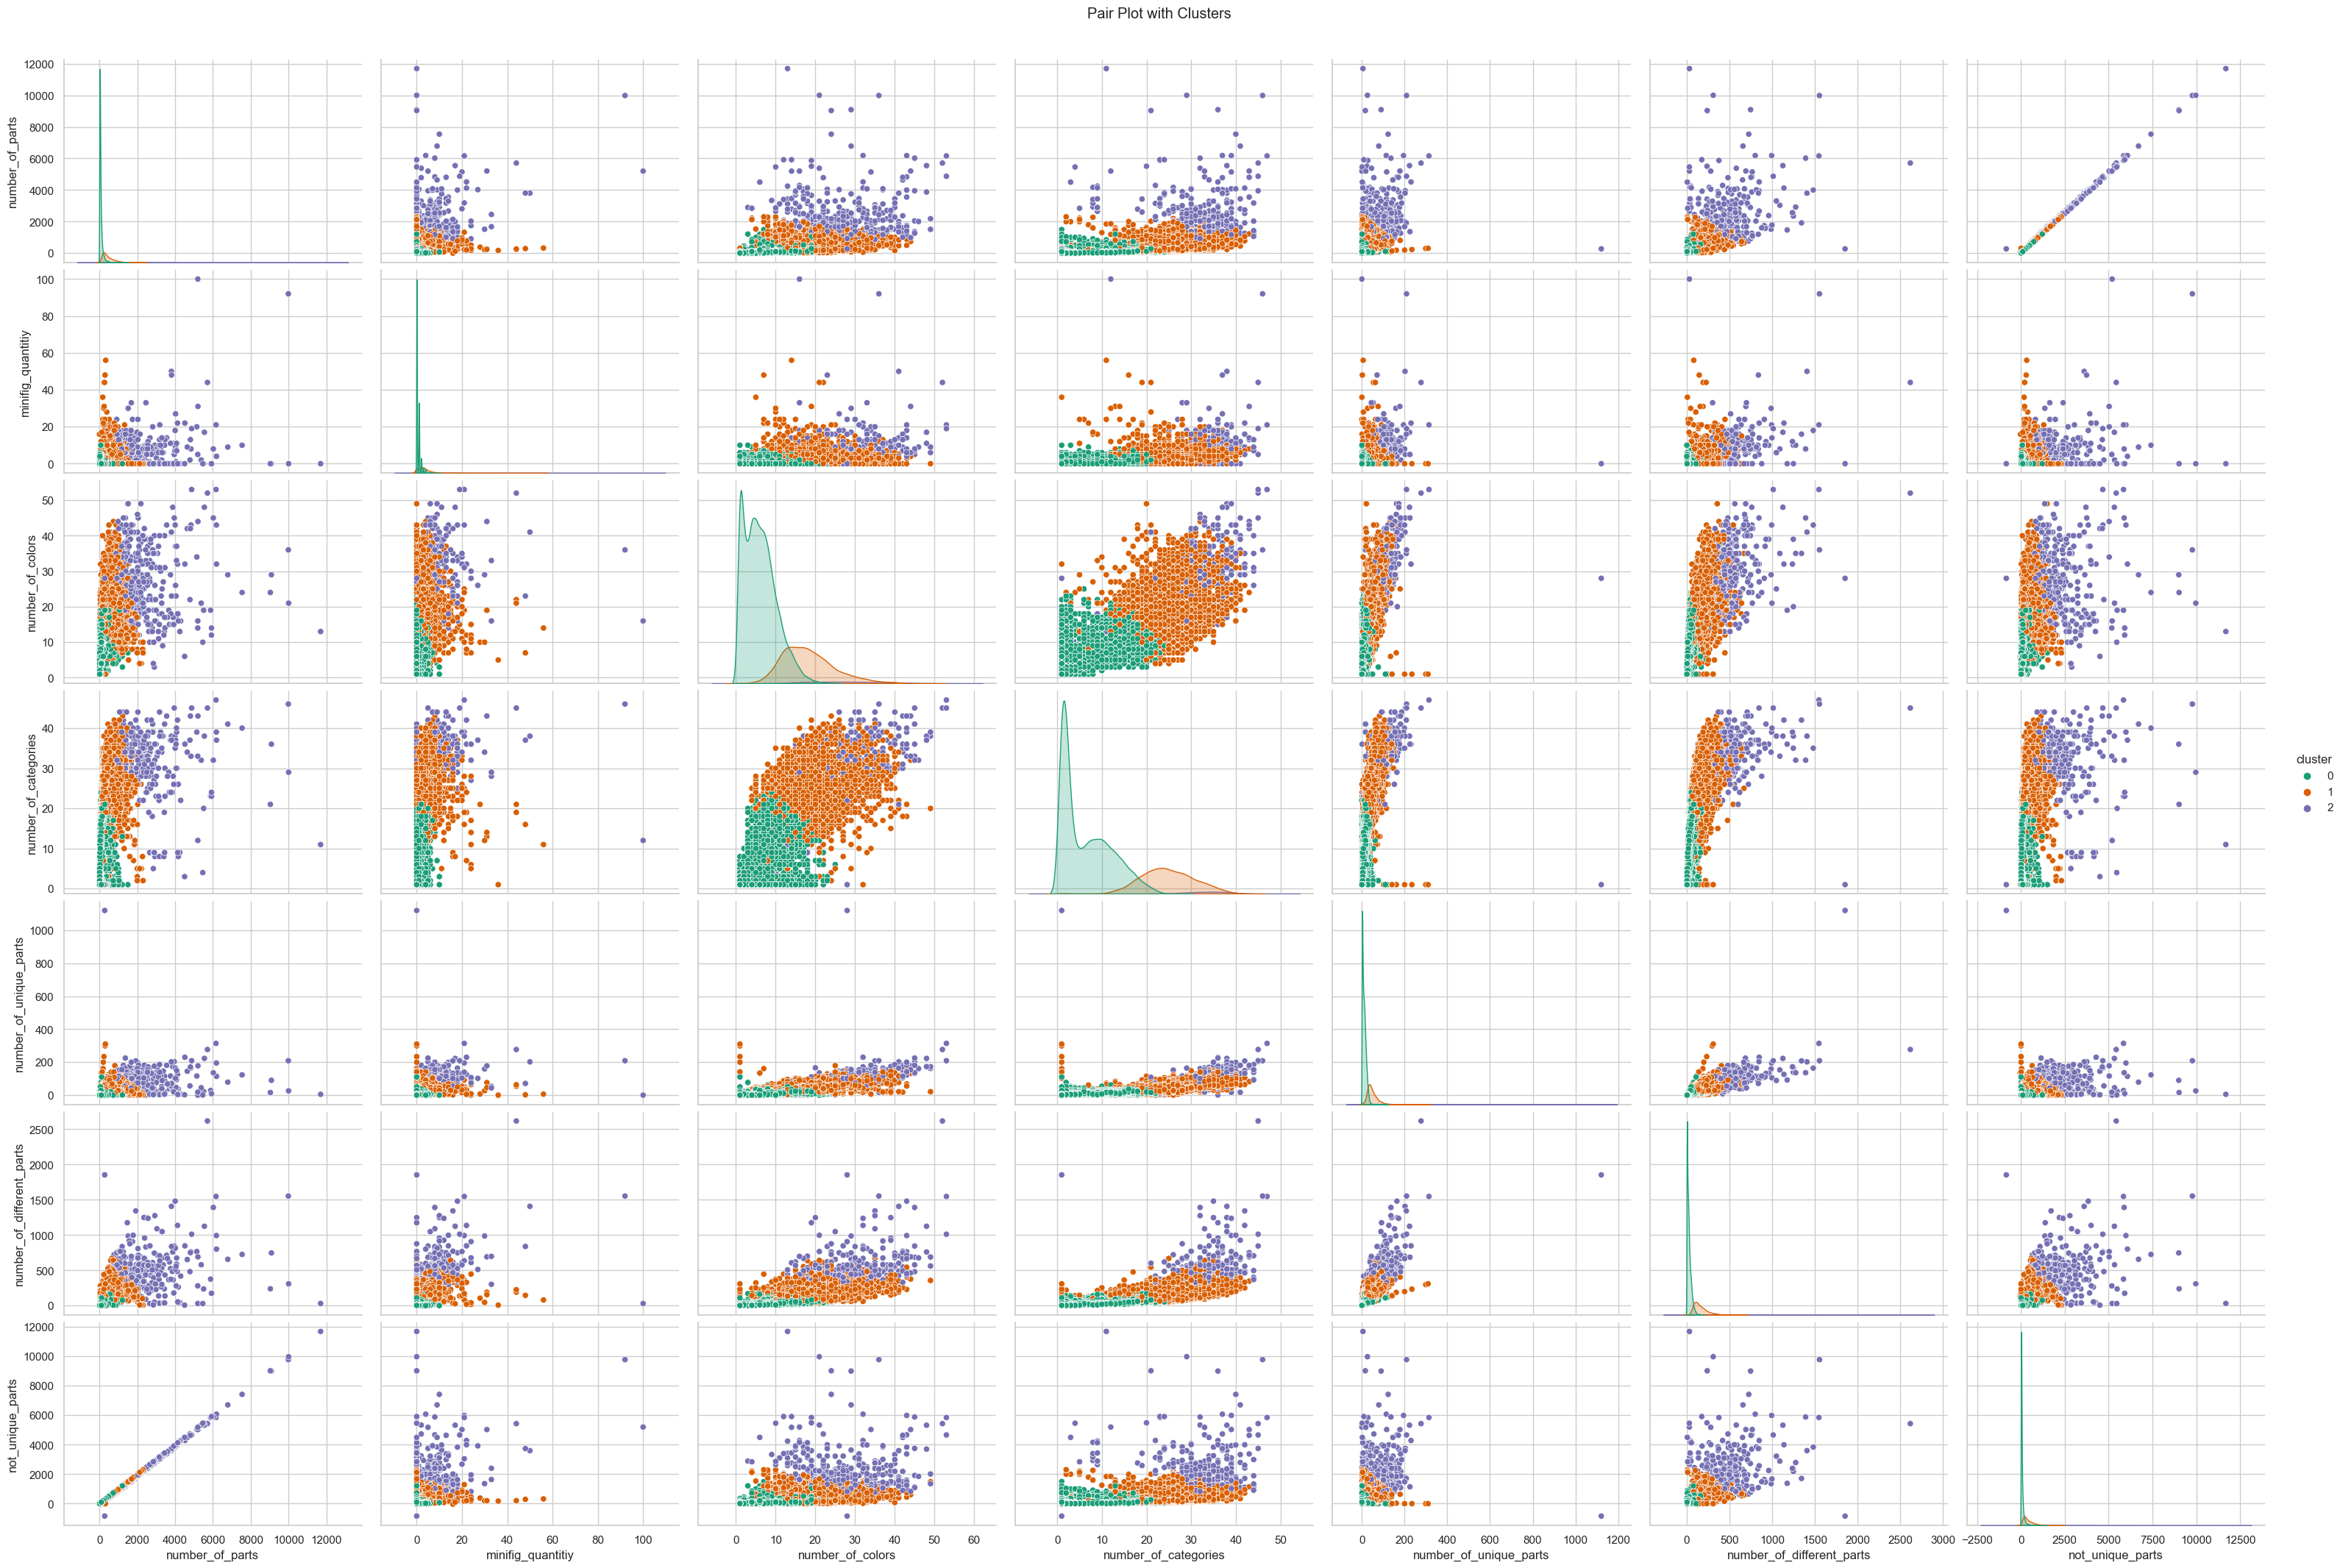

In [234]:
##### Plot the elbow method graph #####

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

# based on the elbow method, choose the optimal number of clusters
optimal_k = 3  # You can change this based on the plot

# perform k-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# add the cluster labels to the original DataFrame
data['cluster'] = clusters

# visualize the clusters using a pair plot
sns.set(style="whitegrid")
sns.pairplot(data, hue='cluster', palette='Dark2', vars=columns_for_clustering, height=3, aspect=1.5)
plt.suptitle('Pair Plot with Clusters', y=1.02)
plt.show()

In [235]:
##### Print means of different factors in the clusters #####

# select only numeric columns for aggregation
numeric_columns = ['number_of_parts', 'minifig_quantitiy', 'number_of_colors',
                    'number_of_categories', 'number_of_unique_parts',
                    'number_of_different_parts', 'not_unique_parts',
                    'proportion_unique_to_not_unique', 'complexity_score']

# ensure numeric columns have the correct data types (convert if necessary)
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# drop rows with missing values
df = data.dropna(subset=numeric_columns)

# group by cluster and calculate mean for numeric columns
cluster_means = data.groupby('cluster')[numeric_columns].mean()

# display the cluster means
print(cluster_means)

         number_of_parts  minifig_quantitiy  number_of_colors   
cluster                                                         
0              64.138532           0.483055          6.110183  \
1             462.909707           3.261680         18.179375   
2            2562.750769           7.603077         27.452308   

         number_of_categories  number_of_unique_parts   
cluster                                                 
0                    6.526582                9.612111  \
1                   24.616316               47.266521   
2                   32.043077               96.716923   

         number_of_different_parts  not_unique_parts   
cluster                                                
0                        23.561034         54.526421  \
1                       159.705640        415.643186   
2                       511.304615       2466.033846   

         proportion_unique_to_not_unique  complexity_score  
cluster                                       

   number_of_parts  minifig_quantitiy  number_of_colors  number_of_categories   
0         0.020758           0.042568          0.118090              0.103292  \
1         0.149819           0.287428          0.351348              0.389585   
2         0.829423           0.670004          0.530563              0.507123   

   number_of_unique_parts  number_of_different_parts  not_unique_parts   
0                0.062581                   0.033922          0.018570  \
1                0.307734                   0.229934          0.141558   
2                0.629686                   0.736144          0.839872   

   complexity_score  
0          0.026037  
1          0.175573  
2          0.798389  


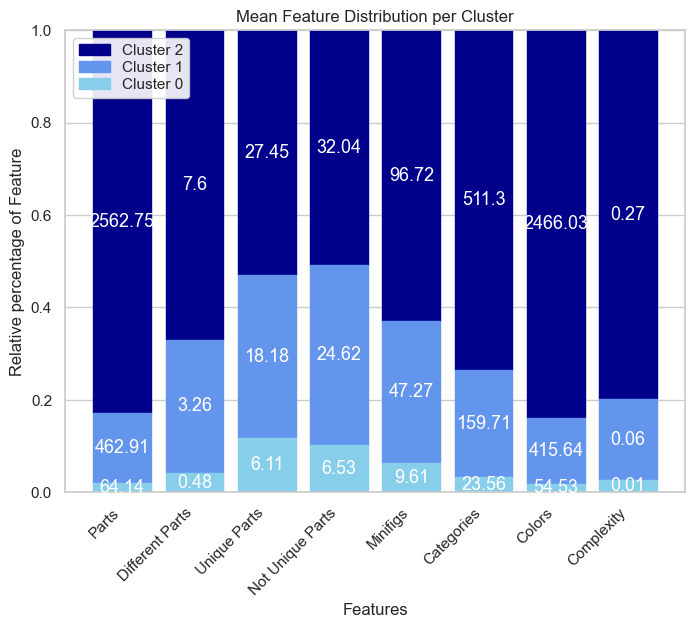

In [243]:
##### Plot the proportion of features in the different clusters #####

# drop proprtion of unique to not unique parts
cluster_data = cluster_means.drop(columns=['proportion_unique_to_not_unique'])

# create feature data
feature_data = {
    'number_of_parts': cluster_means['number_of_parts'].values,
    'minifig_quantitiy': cluster_means['minifig_quantitiy'].values,
    'number_of_colors': cluster_means['number_of_colors'].values,
    'number_of_categories': cluster_means['number_of_categories'].values,
    'number_of_unique_parts': cluster_means['number_of_unique_parts'].values,
    'number_of_different_parts': cluster_means['number_of_different_parts'].values,
    'not_unique_parts': cluster_means['not_unique_parts'].values,
    'complexity_score': cluster_means['complexity_score'].values
}

feature_data = pd.DataFrame(feature_data)

# normalize the data so that each array for each feature adds up to 1
normalized_data = feature_data.div(feature_data.sum(axis=0), axis=1)
print(normalized_data)

fig, ax = plt.subplots(figsize=(8,6))

# calculate clusters
cluster_0 = normalized_data.values[0]
cluster_1 = normalized_data.values[1]
cluster_2 = normalized_data.values[2]
cluster_0_plus_cluster_1 = cluster_0 + cluster_1

# Round and convert to strings
cluster_0_labels = [str(round(value, 2)) for value in cluster_data.values[0]]
cluster_1_labels = [str(round(value, 2)) for value in cluster_data.values[1]]
cluster_2_labels = [str(round(value, 2)) for value in cluster_data.values[2]]

features = ['Parts', 'Different Parts', 'Unique Parts', 'Not Unique Parts', 'Minifigs', 'Categories', 'Colors', 
            'Complexity']

# plot the normalized features

b = ax.bar(features, cluster_2, bottom=cluster_0_plus_cluster_1, color='darkblue', label= "Cluster 2", edgecolor='darkblue')
ax.bar_label(b, padding=0, labels=cluster_2_labels, color = 'w', fontsize = 13, label_type="center")

b = ax.bar(features, cluster_1, bottom=cluster_0, color='cornflowerblue', label= "Cluster 1", edgecolor='cornflowerblue')
ax.bar_label(b, padding=0, labels=cluster_1_labels, color = 'w', fontsize = 13, label_type="center")

b = ax.bar(features, cluster_0, color='skyblue', label="Cluster 0", edgecolor='skyblue')
ax.bar_label(b, padding=0, labels=np.array(cluster_0_labels), color = 'w', fontsize = 13, label_type="center")

# add title, labels and x-ticks
ax.set_xticks(features)
ax.set_xlabel("Features")
ax.set_title('Mean Feature Distribution per Cluster')
ax.legend(loc = 'upper left', framealpha = 0.9, labelspacing= 0.2)
ax.set_ylabel("Relative percentage of Feature")
ax.set_ylim(0,1)
plt.xticks(rotation=45, ha='right')

# save plot
plt.savefig('../Images/Clusters_features.pdf', bbox_inches=matplotlib.transforms.Bbox([[0.0, -1.0], [7.5, 6.0]]))

# show plot
plt.show()

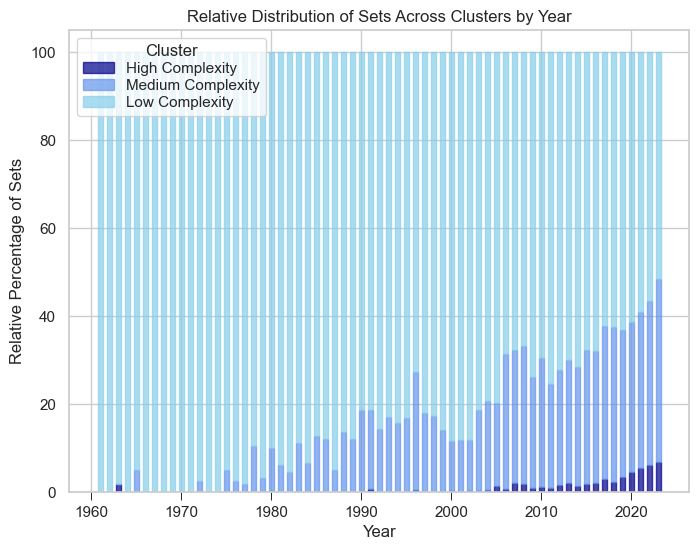

In [237]:
##### Plot the relative percentage of sets in each cluster for every year #####

# group by year and cluster, and calculate the relative percentage
cluster_year_counts = df.groupby(['year', 'cluster']).size().reset_index(name='set_count')
cluster_year_counts['relative_percentage'] = (cluster_year_counts.groupby('year')['set_count'].transform(lambda x: x / x.sum()) * 100)

# pivot the DataFrame to have clusters as columns
pivot_df = cluster_year_counts.pivot(index='year', columns='cluster', values='relative_percentage').fillna(0)

# create the figure and axes
fig, ax = plt.subplots(figsize=(8,6))

# plot the stacked bar plot using ax.bar
years = pivot_df.index
clusters_plot = pivot_df.columns
bottom_values = pd.Series(0, index=years)
colors = ['darkblue', 'cornflowerblue', 'skyblue']

cluster_labels = {
    0: 'Low Complexity',
    1: 'Medium Complexity',
    2: 'High Complexity'}

# reverse the order of clusters
for cluster, color in zip(reversed(clusters_plot), colors):
    ax.bar(
        years,
        pivot_df[cluster],
        bottom=bottom_values,
        label=cluster_labels[cluster],
        alpha=0.7,
        color=color,
        edgecolor=color,
        width=0.603
    )
    bottom_values += pivot_df[cluster]

# add title, labels and x-ticks
ax.set_title('Relative Distribution of Sets Across Clusters by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Relative Percentage of Sets')
plt.tick_params(axis='x', which='major', bottom=True, width=0.7)    
ax.legend(title='Cluster', labelspacing= 0.2, loc='upper left')

# save plot
plt.savefig('../Images/Clusters.pdf', bbox_inches=matplotlib.transforms.Bbox([[0.0, 0.0], [7.5, 6.0]]))

# show plot
plt.show()


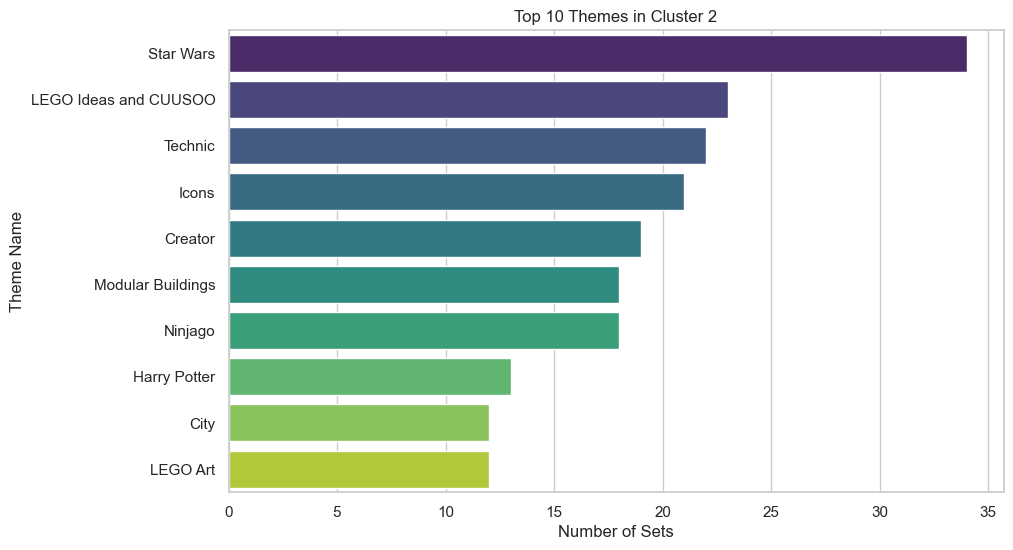

In [238]:
##### Plot 10 most complex themes ##### 

# assuming that cluster 2 accounts for the most complex sets, find out which themes are the most complex
cluster_2_df = df[df['cluster'] == 2]

# get the 10 most common themes in Cluster 2
top_10_themes_cluster_2 = cluster_2_df['theme_name'].value_counts().head(10)

# plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_themes_cluster_2.values, y=top_10_themes_cluster_2.index, palette='viridis')
plt.title('Top 10 Themes in Cluster 2')
plt.xlabel('Number of Sets')
plt.ylabel('Theme Name')
plt.show()

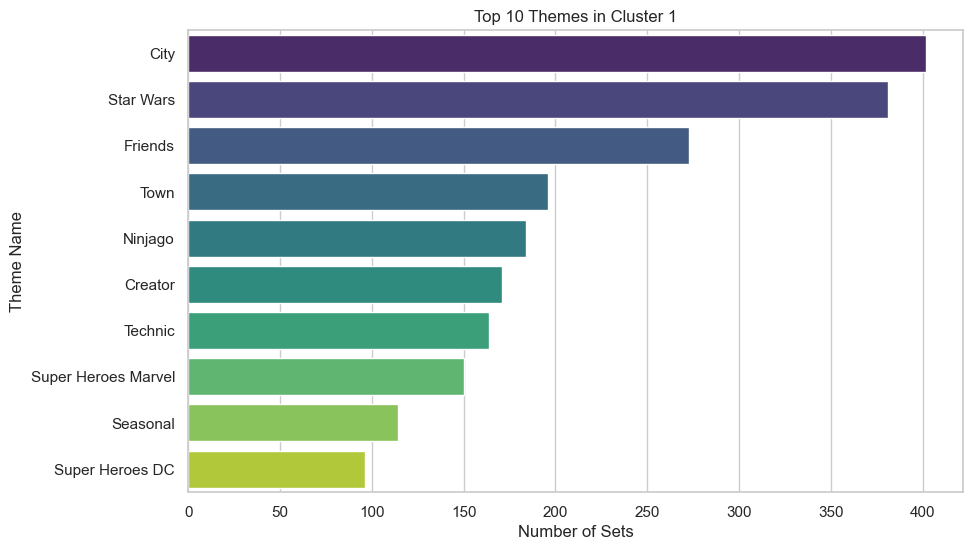

In [239]:
##### 10 middle complex themes #####

# assuming that cluster 1 accounts for the middle complex sets
cluster_1_df = df[df['cluster'] == 1]

# get the 10 most common themes in Cluster 1
top_10_themes_cluster_1 = cluster_1_df['theme_name'].value_counts().head(10)

# plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_themes_cluster_1.values, y=top_10_themes_cluster_1.index, palette='viridis')
plt.title('Top 10 Themes in Cluster 1')
plt.xlabel('Number of Sets')
plt.ylabel('Theme Name')
plt.show()


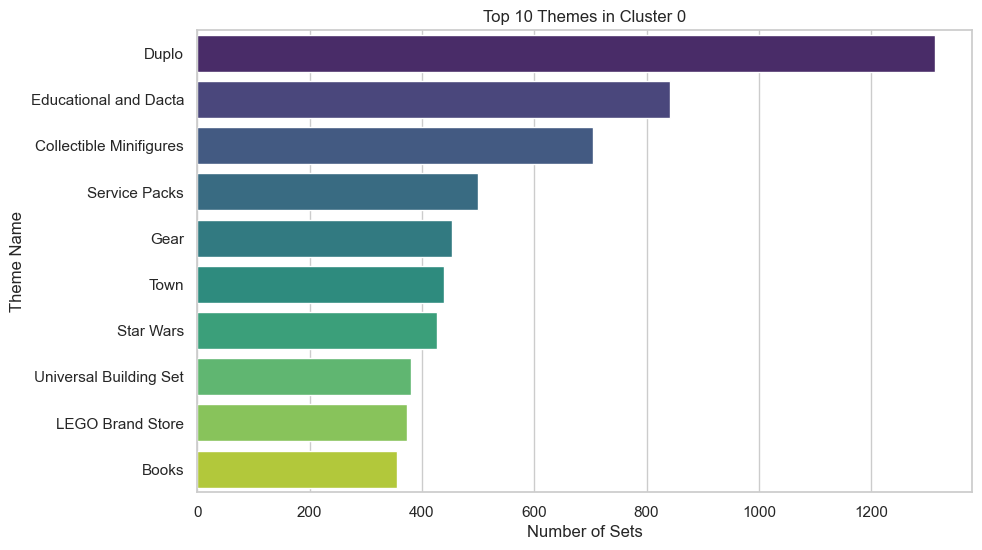

In [240]:
##### 10 low complex themes #####

# assuming that cluster 2 accounts for the lowest complex sets
cluster_0_df = df[df['cluster'] == 0]

# get the 10 most common themes in Cluster 1
top_10_themes_cluster_0 = cluster_0_df['theme_name'].value_counts().head(10)

# plot the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_themes_cluster_0.values, y=top_10_themes_cluster_0.index, palette='viridis')
plt.title('Top 10 Themes in Cluster 0')
plt.xlabel('Number of Sets')
plt.ylabel('Theme Name')
plt.show()

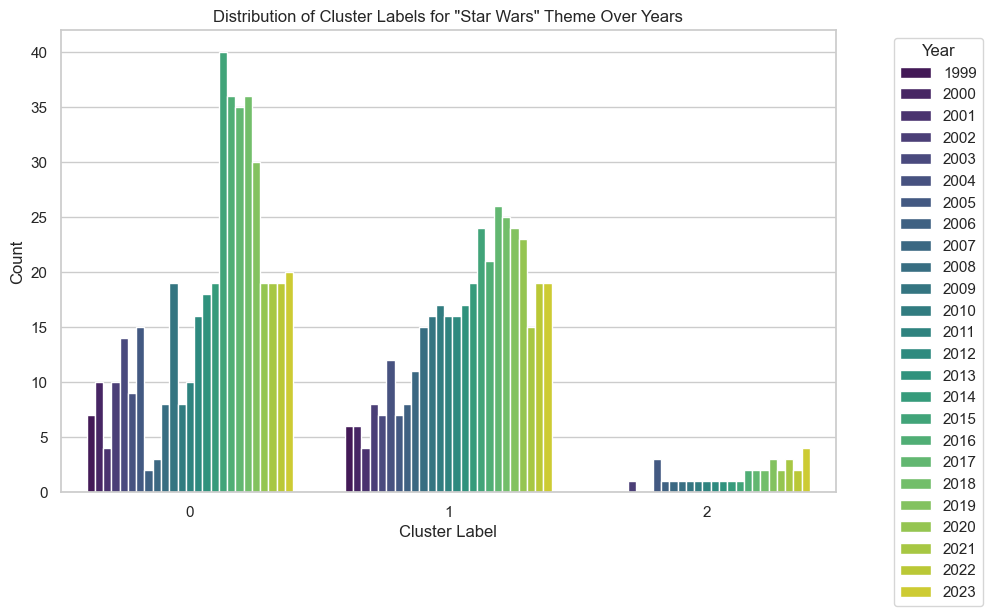

In [241]:
##### Plot the change of Star Wars complexity #####

# filter the DataFrame for sets with theme name "Star Wars"
star_wars_df = df[df['theme_name'] == 'Star Wars']

# plot the count of cluster labels for "Star Wars" theme over the years
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', hue='year', data=star_wars_df, palette='viridis')
plt.title('Distribution of Cluster Labels for "Star Wars" Theme Over Years')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

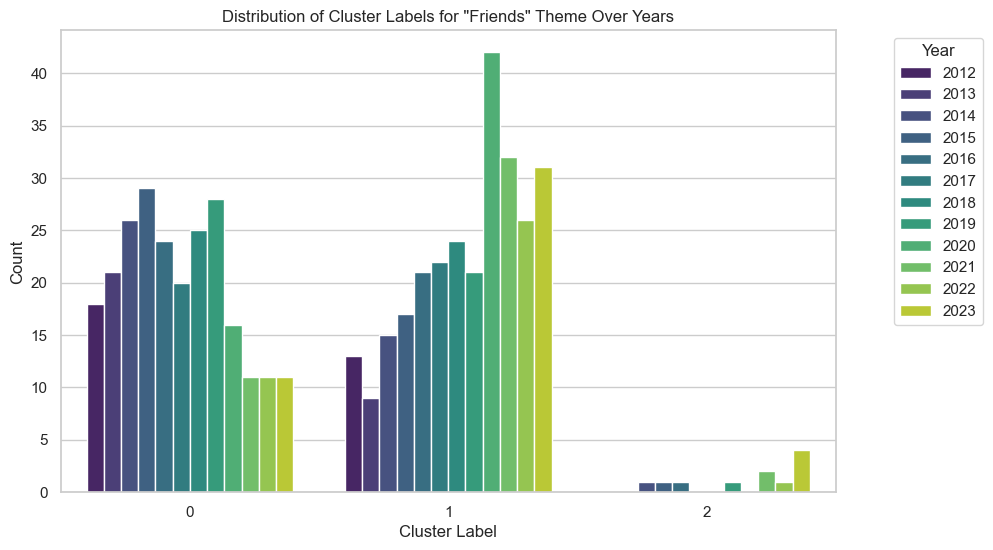

In [242]:
##### Plot the change of Friends complexity #####

# filter the DataFrame for sets with theme name "Star Wars"
friends_df = df[df['theme_name'] == 'Friends']

# plot the count of cluster labels for "Friends" theme over the years
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', hue='year', data=friends_df, palette='viridis')
plt.title('Distribution of Cluster Labels for "Friends" Theme Over Years')
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.legend(title='Year', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()